In [65]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from math import log10, sqrt
from skimage.metrics import structural_similarity as ssim
from numpy.fft import fft2, ifft2
from scipy.signal import wiener
import skimage.filters as flt
from skimage.restoration import (denoise_tv_chambolle,denoise_nl_means)
import bm3d

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

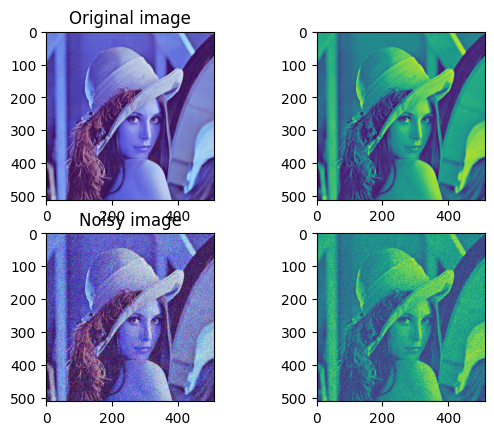

In [12]:
image_noisy = cv.imread('Lenna_(noisy_image).png')
image_orig = cv.imread('Lenna_(original_image).png')
	
gray_orig = cv.cvtColor(image_orig, cv.COLOR_BGR2GRAY)
gray_noisy = cv.cvtColor(image_noisy, cv.COLOR_BGR2GRAY)

fig,axes = plt.subplots(2,2)
axes[0,0].imshow(image_orig)
axes[0,0].set_title('Original image')
axes[0,1].imshow(gray_orig)
axes[1,0].imshow(image_noisy)
axes[1,1].imshow(gray_noisy)
axes[1,0].set_title('Noisy image')

plt.tight_layout

In [14]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [16]:
PSNR_orig = PSNR(gray_orig, gray_noisy)
PSNR_orig

28.179041143195708

In [19]:
SSIM = ssim(gray_orig, gray_noisy)
SSIM

0.2275320694939274

In [ ]:
def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):
	
	# ...you could always diffuse each color channel independently if you
	# really want
	if img.ndim == 3:
		img = img.mean(2)

	# initialize output array
	img = img.astype('float32')
	imgout = img.copy()

	# initialize some internal variables
	deltaS = np.zeros_like(imgout)
	deltaE = deltaS.copy()
	NS = deltaS.copy()
	EW = deltaS.copy()
	gS = np.ones_like(imgout)
	gE = gS.copy()

	# create the plot figure, if requested
	if ploton:
		import pylab as pl
		from time import sleep

		fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
		ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

		ax1.imshow(img,interpolation='nearest')
		ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
		ax1.set_title("Original image")
		ax2.set_title("Iteration 0")

		fig.canvas.draw()

	for ii in np.arange(1,niter):

		# calculate the diffs
		deltaS[:-1,: ] = np.diff(imgout,axis=0)
		deltaE[: ,:-1] = np.diff(imgout,axis=1)

		if 0<sigma:
			deltaSf=flt.gaussian_filter(deltaS,sigma);
			deltaEf=flt.gaussian_filter(deltaE,sigma);
		else: 
			deltaSf=deltaS;
			deltaEf=deltaE;
			
		# conduction gradients (only need to compute one per dim!)
		if option == 1:
			gS = np.exp(-(deltaSf/kappa)**2.)/step[0]
			gE = np.exp(-(deltaEf/kappa)**2.)/step[1]
		elif option == 2:
			gS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
			gE = 1./(1.+(deltaEf/kappa)**2.)/step[1]

		# update matrices
		E = gE*deltaE
		S = gS*deltaS

		# subtract a copy that has been shifted 'North/West' by one
		# pixel. don't as questions. just do it. trust me.
		NS[:] = S
		EW[:] = E
		NS[1:,:] -= S[:-1,:]
		EW[:,1:] -= E[:,:-1]

		# update the image
		imgout += gamma*(NS+EW)

		if ploton:
			iterstring = "Iteration %i" %(ii+1)
			ih.set_data(imgout)
			ax2.set_title(iterstring)
			fig.canvas.draw()
			# sleep(0.01)

	return imgout

In [82]:
Gaussian_filter = cv.blur(gray_noisy,(5,5))
Bilateral_filter = cv.bilateralFilter(gray_noisy,9,75,75)
Wiener_filter= wiener(gray_noisy, (3,3))
AD_filter = anisodiff(gray_noisy)
TV_filter = denoise_tv_chambolle(gray_noisy)
NLM_filter = denoise_nl_means(gray_noisy)

Text(0.5, 1.0, 'NLM')

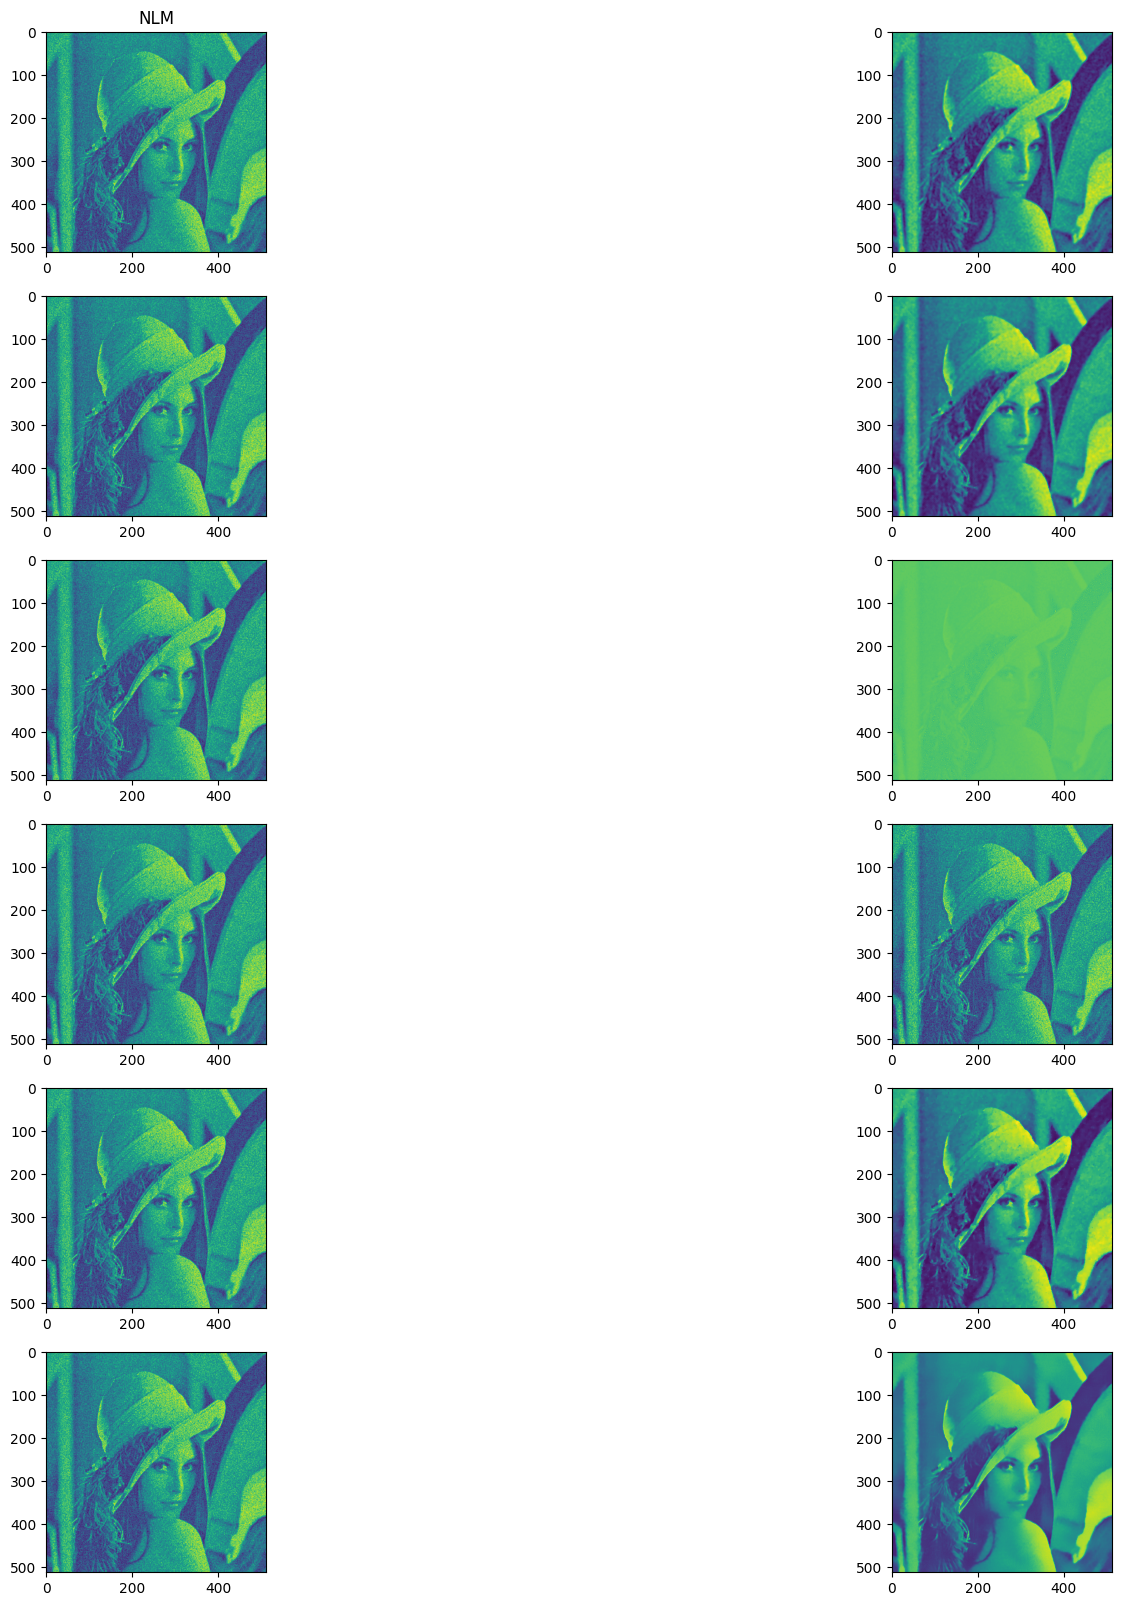

In [83]:
fig,axes = plt.subplots(6,2,figsize=(20,20))
axes[0,0].imshow(gray_noisy)
axes[0,1].imshow(Gaussian_filter)
axes[0,0].set_title('Gaussian')

axes[1,0].imshow(gray_noisy)
axes[1,1].imshow(Bilateral_filter)
axes[0,0].set_title('Bilateral')

axes[2,0].imshow(gray_noisy)
axes[2,1].imshow(Wiener_filter)
axes[0,0].set_title('Wiener')

axes[3,0].imshow(gray_noisy)
axes[3,1].imshow(AD_filter)
axes[0,0].set_title('AD')

axes[4,0].imshow(gray_noisy)
axes[4,1].imshow(TV_filter)
axes[0,0].set_title('TV')

axes[5,0].imshow(gray_noisy)
axes[5,1].imshow(NLM_filter)
axes[0,0].set_title('NLM')